In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the data
genotypes = pd.read_csv('tomatoes/Genotypic_data_maf10_min10_291acc.txt', index_col=0)
phenotype = pd.read_csv('tomatoes/phenodata_BLUP_2012.txt', sep='\t', index_col='ID')

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    genotypes, phenotype['FREAR'], test_size=0.2, random_state=42)

In [4]:
# Function to calculate minor allele frequency
def calculate_maf(df):
    maf = df.apply(lambda x: min(x.mean(), 1 - x.mean()), axis=0)
    return maf

# Function for LD pruning
def ld_pruning(df, threshold=0.5):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Updated to use bool
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [5]:
# Apply MAF and LD pruning only to the training set
maf = calculate_maf(X_train)
X_train_filtered = X_train.loc[:, maf > 0.05]  # Filter out SNPs with MAF <= 5%
X_train_pruned = ld_pruning(X_train_filtered)

In [6]:
# Impute missing data and scale the data
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_pruned), columns=X_train_pruned.columns)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_pruned.columns)

# Apply the same imputation and scaling transformations to the test set
X_test_filtered = X_test[X_train_pruned.columns]  # Keep only the columns that survived pruning
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_train_pruned.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_train_pruned.columns)

In [7]:
# Lasso for feature selection with cross-validation
lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000)  # Increased number of iterations
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [8]:
# Extract the coefficients and the features selected by Lasso
selected_features = X_train_scaled.columns[lasso_cv.coef_ != 0]
# Export selected features to CSV
selected_features_df = pd.Series(selected_features)
selected_features_df.to_csv('selected_features_lasso.csv', index=False)

In [9]:
# Using selected features for modeling
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [10]:
# Linear regression with cross-validation for prediction
regressor = LinearRegression()
cv_scores = cross_val_score(regressor, X_train_selected, y_train, cv=5, scoring='neg_root_mean_squared_error')


In [11]:
# Fit the model
regressor.fit(X_train_selected, y_train)
y_pred = regressor.predict(X_test_selected)

In [12]:
# Calculate RMSE and R-squared for test data
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
# Mean RMSE from cross-validation
mean_cv_rmse = -np.mean(cv_scores)

In [13]:
print(f"Mean CV RMSE: {mean_cv_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

Mean CV RMSE: 2.05787905961106
Test RMSE: 2.3911754678895125
Test R²: 0.19245307578934945


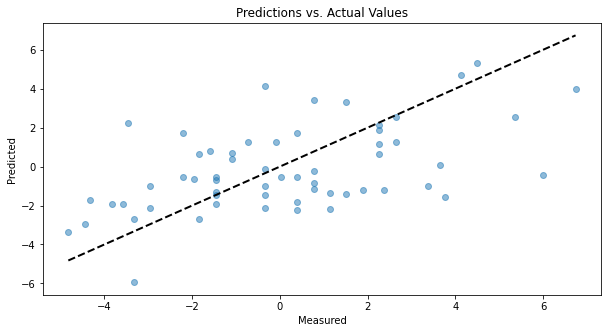

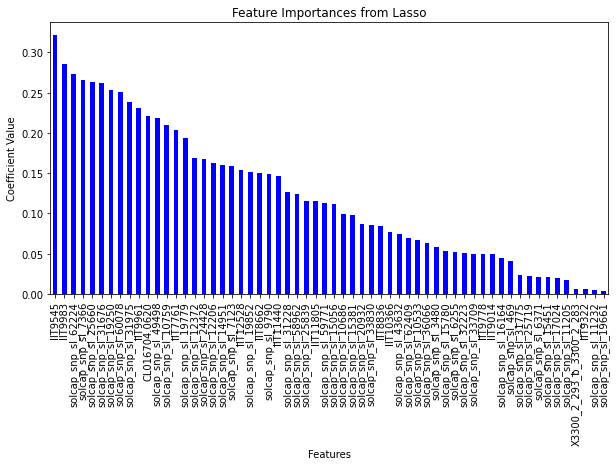

In [14]:
# Visualization of predictions vs. actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predictions vs. Actual Values')
plt.show()

# Plotting feature importances from Lasso
plt.figure(figsize=(10, 5))
coefficients = pd.Series(lasso_cv.coef_[lasso_cv.coef_ != 0], index=selected_features)
sorted_coeffs = coefficients.abs().sort_values(ascending=False)
plt.title('Feature Importances from Lasso')
sorted_coeffs.plot(kind='bar', color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()